    Retrieve maximum BRDF first.

In [3]:
%run MCM_SMB_retrieval.py

ERROR:root:File `'MCM_SMB_retrieval.py'` not found.



    Author@Yizhe

    Created on Oct 1, 2019

    Retrieve the surface ID from the maxBRF_XX_DoY.nc dataset.  
    Running this script to generate SurfaceID_PTA_xxx.nc data files storing the surface ID and the representative BRDF for each surface category for the specified PTA.

In [3]:
import numpy as np
import xarray as xr
from sklearn.cluster import MiniBatchKMeans

    use xarray.open_mfdataset to implement dask multi-processor.  

    the data array -- target_max_brf -- contains three fillin values:  
    
    (1) -997. : these points are preset for water category (consist of shallow and deep ocean);  
    (2) -998. : these points are preset for coastal category (consist of coastline, P. shallow inland water, S. inland water, P. deep inland water);  
    (3) -999. : these points are neither MAIA-water nor MAIA-coastal and have invalid RTLS coefficients for more than 5 years.

In [4]:
DS = xr.open_mfdataset('MAIAC_SMB/maxBRF_LA_048.nc')
print(DS)

<xarray.Dataset>
Dimensions:    (cos_sza: 10, raz: 12, vza: 15, x: 1000, y: 1000)
Coordinates:
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * cos_sza    (cos_sza) float64 0.05 0.15 0.25 0.35 ... 0.65 0.75 0.85 0.95
  * vza        (vza) float64 2.5 7.5 12.5 17.5 22.5 ... 52.5 57.5 62.5 67.5 72.5
  * raz        (raz) float64 7.5 22.5 37.5 52.5 67.5 ... 127.5 142.5 157.5 172.5
Data variables:
    max_BRF    (y, x, cos_sza, vza, raz) float64 dask.array<shape=(1000, 1000, 10, 15, 12), chunksize=(1000, 1000, 10, 15, 12)>
    Latitude   (y, x) float64 dask.array<shape=(1000, 1000), chunksize=(1000, 1000)>
    Longitude  (y, x) float64 dask.array<shape=(1000, 1000), chunksize=(1000, 1000)>


    ===========K-means clustering===========

In [5]:
sel_data = DS.max_BRF.sel(vza=[2.5, 27.5, 42.5, 62.5, 72.5], 
                          raz=[22.5, 52.5, 97.5, 127.5, 157.5]
                         )

# sel_data = DS.max_BRF
filled_sel_data = sel_data.fillna(-996.)
print(filled_sel_data)

<xarray.DataArray 'max_BRF' (y: 1000, x: 1000, cos_sza: 10, vza: 5, raz: 5)>
dask.array<shape=(1000, 1000, 10, 5, 5), dtype=float64, chunksize=(1000, 1000, 10, 5, 5)>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * cos_sza  (cos_sza) float64 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95
  * vza      (vza) float64 2.5 27.5 42.5 62.5 72.5
  * raz      (raz) float64 22.5 52.5 97.5 127.5 157.5


In [6]:
sample_data = filled_sel_data[:, :, 0, 0, 0]
idx_coastal = np.where(sample_data==-997.)
idx_water = np.where(sample_data==-998.)
idx_unknown = np.where(sample_data==-996.)

In [5]:
# print(idx_coastal[0].shape[0], idx_water[0].shape[0], idx_unknown[0].shape[0])

(14473, 371087, 415)


In [7]:
stacked_filled_sel_data = sel_data.stack(i=('y', 'x'), z=('cos_sza', 'vza', 'raz'))
input_data = stacked_filled_sel_data.values

In [8]:
# whiten data -- equivalent to using sklearn.preprocessing.StandardScaler
np.place(input_data, input_data<-900., np.nan)
input_data_mean = np.nanmean(input_data, axis=0)
input_data_std = np.nanstd(input_data, axis=0)
whitened_data = (input_data - input_data_mean) / input_data_std
idx_nan = xr.ufuncs.isnan(whitened_data)
whitened_data[idx_nan] = -9999.

/data/gdi/b/yizhe/anaconda3/envs/trend_analysis/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [28]:
n_clusters = 23

# cluster the whitened data
minibatch_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    init='k-means++',
    random_state=0,
    batch_size=1000,
    verbose=0,
    max_no_improvement=100).fit(whitened_data)

unsorted_labels = minibatch_kmeans.labels_.reshape(1000, 1000)

    ===========sort labels===========

calculate grid_mean_BRF

In [29]:
grid_mean_BRF = stacked_filled_sel_data.unstack('i').mean(axis=0).values

use grid_mean_BRF to get unsorted_cluster_mean_BRF

In [30]:

unsorted_cluster_mean_BRF = []
for icluster in np.arange(n_clusters):
    _cluster_BRF = grid_mean_BRF[unsorted_labels == icluster]
    unsorted_cluster_mean_BRF.append(np.nanmean(_cluster_BRF))

get sorted_labels based on unsorted_cluster_mean_BRF (small to large)

In [31]:

# assign a number to each cluster_mean_BRF
unsorted_clusters = np.dstack([range(n_clusters), unsorted_cluster_mean_BRF])[0]

# sort the rest
sorted_clusters = np.array(sorted(unsorted_clusters, key=lambda x: x[1]))[:, 0]

# sort labels (0--n_clusters where category 0 is for unconsidered points)
sorted_labels = unsorted_labels.copy()
for i, j in enumerate(sorted_clusters):
    np.place(sorted_labels, unsorted_labels==j, 101+i)
sorted_labels -= 100

# 
sorted_labels[idx_water] = 0
sorted_labels[idx_coastal] = 1
sorted_labels[idx_unknown] = 1

use sorted_labels to calculate some statistics within each sorted cluster

In [32]:

sorted_cluster_std_BRF = []
sorted_cluster_mean_BRF = []
sorted_cluster_tot_num = []

# plus 1 because adding water type (0)
for icluster in np.arange(n_clusters+1):
    _cluster_BRF = grid_mean_BRF[sorted_labels == icluster]
    
    sorted_cluster_mean_BRF.append(np.nanmean(_cluster_BRF))
    sorted_cluster_std_BRF.append(np.nanstd(_cluster_BRF))
    sorted_cluster_tot_num.append(len(_cluster_BRF))
    
    print "{:2d} {:6d} {:.2f} {:.2f}".format(icluster, sorted_cluster_tot_num[icluster], 
                    sorted_cluster_mean_BRF[icluster], sorted_cluster_std_BRF[icluster])
    
    

 0 371087 -998.00 0.00
 1  14888 -997.00 0.00
 2  25434 0.06 0.01
 3  53355 0.09 0.01
 4  51533 0.12 0.01
 5  26530 0.12 0.01
 6  37521 0.15 0.01
 7  50814 0.16 0.01
 8  23404 0.17 0.02
 9  42952 0.18 0.01
10  58880 0.20 0.01
11  44913 0.22 0.01
12  11309 0.22 0.02
13  18409 0.24 0.02
14  38376 0.24 0.01
15  36038 0.25 0.01
16  28499 0.29 0.01
17   5242 0.30 0.03
18  16398 0.31 0.02
19  16795 0.33 0.02
20  10861 0.39 0.03
21   1802 0.40 0.04
22   8933 0.41 0.03
23   6027 0.47 0.03


    Retrieve maximum BRF

In [ ]:
# calculate category-wise BRDF stats (max&min&mean)
ncats = np.arange(2, n_clusters)
cat_BRDF_stats = []
for icat in ncats:
    idx_cat = np.where(sorted_labels == icat)
    cat_BRDF_stats.append(np.max(TARGET_max_brf[idx_cat], axis=0))

    Save surface ID!

In [52]:
out_nc = "SurfaceID_LA_048.nc"

MAIA_lats = DS.Latitude
MAIA_lons = DS.Longitude
MAIA_lats.to_netcdf(out_nc, 'w')
MAIA_lons.to_netcdf(out_nc, 'a')

MAIA_labels = xr.DataArray(sorted_labels, name='surface_ID',
                           dims=['y', 'x'],
                           coords = {'lat': (('y', 'x'), MAIA_lats),
                                     'lon': (('y', 'x'), MAIA_lons)})
MAIA_labels.to_netcdf(out_nc, 'a')

    ===========show labels===========

<IPython.core.display.Javascript object>


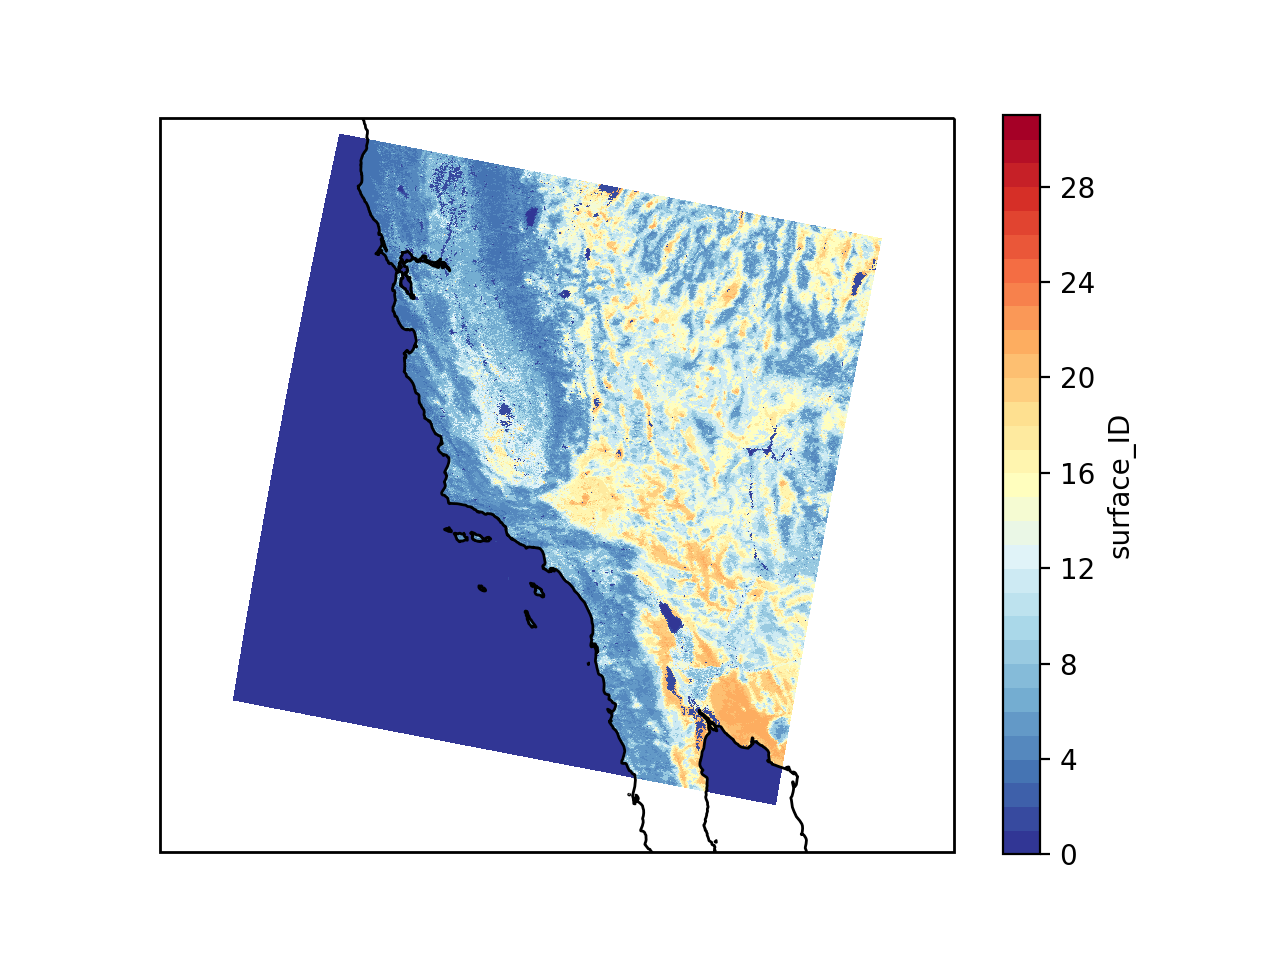

In [54]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib notebook


DS_sfcID = xr.open_dataset('SurfaceID_LA_048.nc')
sfcID = DS_sfcID.surface_ID

ax = plt.axes(projection=ccrs.Orthographic(-100, 35))

# sfcID.plot.imshow(levels=23, vmax=22, origin='upper', cmap='RdYlBu_r')
sfcID.plot.pcolormesh('lon', 'lat', ax=ax, transform=ccrs.PlateCarree(), levels=n_clusters+2, vmax=n_clusters, cmap='RdYlBu_r');

ax.set_global()
ax.coastlines(resolution='10m')

plt.show()